# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

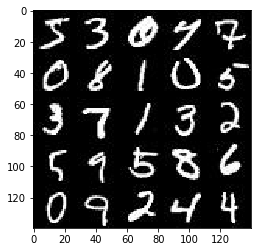

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

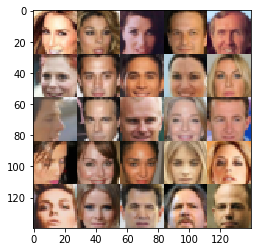

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8144... Generator Loss: 1.2341
Epoch 1/2... Discriminator Loss: 0.5384... Generator Loss: 2.0159
Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 3.4745
Epoch 1/2... Discriminator Loss: 0.4079... Generator Loss: 3.6233
Epoch 1/2... Discriminator Loss: 0.4208... Generator Loss: 3.1638
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 3.1039
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 3.9713
Epoch 1/2... Discriminator Loss: 0.3851... Generator Loss: 4.6356
Epoch 1/2... Discriminator Loss: 0.4832... Generator Loss: 3.9687
Epoch 1/2... Discriminator Loss: 0.3747... Generator Loss: 4.0202


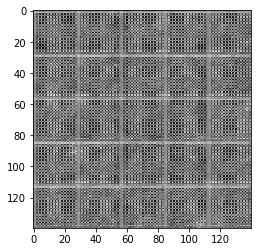

Epoch 1/2... Discriminator Loss: 0.3625... Generator Loss: 4.3135
Epoch 1/2... Discriminator Loss: 0.3831... Generator Loss: 4.7598
Epoch 1/2... Discriminator Loss: 0.3732... Generator Loss: 4.3408
Epoch 1/2... Discriminator Loss: 0.3690... Generator Loss: 4.8289
Epoch 1/2... Discriminator Loss: 0.3885... Generator Loss: 4.0197
Epoch 1/2... Discriminator Loss: 0.3832... Generator Loss: 4.0540
Epoch 1/2... Discriminator Loss: 0.5127... Generator Loss: 3.3011
Epoch 1/2... Discriminator Loss: 0.3885... Generator Loss: 5.8090
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 3.5844
Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 5.4842


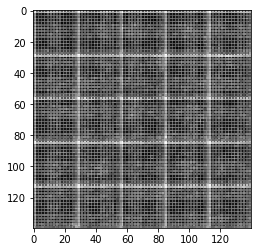

Epoch 1/2... Discriminator Loss: 0.3905... Generator Loss: 3.5522
Epoch 1/2... Discriminator Loss: 4.3929... Generator Loss: 12.0845
Epoch 1/2... Discriminator Loss: 0.4189... Generator Loss: 3.1969
Epoch 1/2... Discriminator Loss: 0.6504... Generator Loss: 1.6398
Epoch 1/2... Discriminator Loss: 0.3863... Generator Loss: 3.4495
Epoch 1/2... Discriminator Loss: 0.4567... Generator Loss: 2.9831
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 2.9604
Epoch 1/2... Discriminator Loss: 0.8616... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 0.5292... Generator Loss: 2.3887
Epoch 1/2... Discriminator Loss: 0.5487... Generator Loss: 2.1479


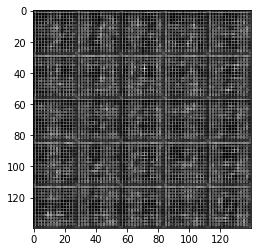

Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 1.3182
Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 1.2647
Epoch 1/2... Discriminator Loss: 0.5068... Generator Loss: 2.6515
Epoch 1/2... Discriminator Loss: 0.5440... Generator Loss: 2.3752
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 1.8949
Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 1.9248
Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 2.3699
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 1.9129
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.6464
Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.1840


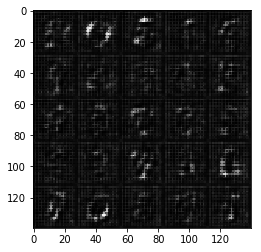

Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 1.8177
Epoch 1/2... Discriminator Loss: 0.6327... Generator Loss: 1.6427
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 2.5461
Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 1.8071
Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 2.4100
Epoch 1/2... Discriminator Loss: 0.6718... Generator Loss: 1.5942
Epoch 1/2... Discriminator Loss: 0.7595... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 1.4664
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 1.5110


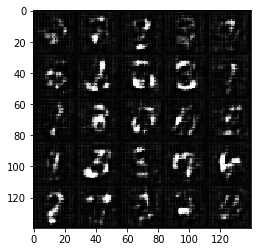

Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 2.1559
Epoch 1/2... Discriminator Loss: 0.6878... Generator Loss: 1.5267
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 2.7984
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 1.6123
Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 2.5449
Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 0.9881
Epoch 1/2... Discriminator Loss: 0.6491... Generator Loss: 1.4777
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 1.3157
Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 1.8588


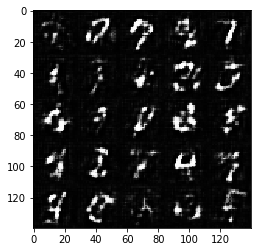

Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 2.0917
Epoch 1/2... Discriminator Loss: 0.6069... Generator Loss: 1.9753
Epoch 1/2... Discriminator Loss: 0.7345... Generator Loss: 1.9121
Epoch 1/2... Discriminator Loss: 0.6394... Generator Loss: 1.6609
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.4419
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.2494
Epoch 1/2... Discriminator Loss: 0.7828... Generator Loss: 2.0959
Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 1.3528
Epoch 1/2... Discriminator Loss: 0.6781... Generator Loss: 2.0758


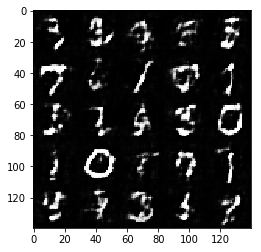

Epoch 1/2... Discriminator Loss: 1.9249... Generator Loss: 0.3867
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.5882
Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.6776
Epoch 1/2... Discriminator Loss: 0.6245... Generator Loss: 1.6889
Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 2.1230
Epoch 1/2... Discriminator Loss: 0.7171... Generator Loss: 1.4418
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 1.0477
Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 0.7643


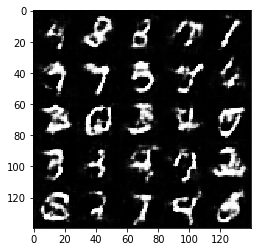

Epoch 1/2... Discriminator Loss: 0.8187... Generator Loss: 1.4008
Epoch 1/2... Discriminator Loss: 0.7341... Generator Loss: 1.8468
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.3724
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 2.0465
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 1.4094
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.4494
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 2.1421
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.1103
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.7077
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.7646


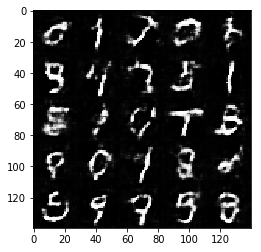

Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.5707
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 1.4126
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.2726
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 0.9267
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.5796
Epoch 2/2... Discriminator Loss: 0.7112... Generator Loss: 1.6792
Epoch 2/2... Discriminator Loss: 0.9954... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 1.4873
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.2742
Epoch 2/2... Discriminator Loss: 0.8078... Generator Loss: 1.2844


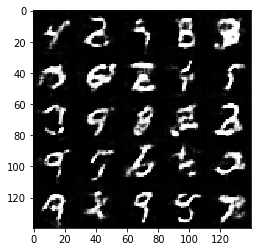

Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.6813
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 1.8563
Epoch 2/2... Discriminator Loss: 0.8954... Generator Loss: 1.9955
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.3464
Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 1.9265
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 0.9083
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.5328
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 1.4123
Epoch 2/2... Discriminator Loss: 0.7309... Generator Loss: 1.8545
Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.5696


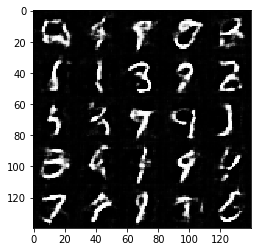

Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.7257
Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 1.8121
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 1.2522
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 1.7099
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 1.1132
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 1.5212
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 0.9383
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 1.6064


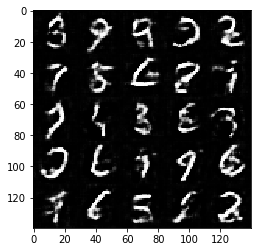

Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.6975
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 2.5883
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.1384
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.2954
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 2.3281
Epoch 2/2... Discriminator Loss: 0.9629... Generator Loss: 1.8656
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.3909
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 2.3696
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 1.3329


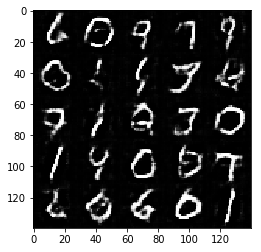

Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.0787
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.2410
Epoch 2/2... Discriminator Loss: 0.8435... Generator Loss: 1.5350
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.8020
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.3175
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.3657
Epoch 2/2... Discriminator Loss: 0.8242... Generator Loss: 1.8361
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.6063
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.6369
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.5443


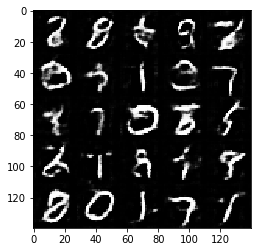

Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.1182
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 1.2604
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 1.5377
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 1.5986
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 1.7854
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.3187
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 1.3028
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 1.4773


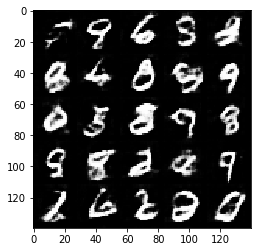

Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.1678
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 1.5882
Epoch 2/2... Discriminator Loss: 0.6702... Generator Loss: 1.7069
Epoch 2/2... Discriminator Loss: 0.7029... Generator Loss: 2.1511
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.3476
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.6363
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 1.1560
Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 1.3522
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.8378
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.1455


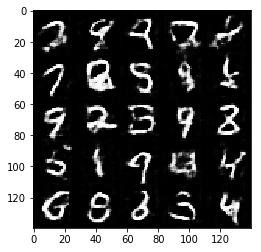

Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.1082
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.0403
Epoch 2/2... Discriminator Loss: 0.8504... Generator Loss: 1.2944
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 1.7299
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 1.2440
Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 1.7333
Epoch 2/2... Discriminator Loss: 0.7201... Generator Loss: 1.6071
Epoch 2/2... Discriminator Loss: 0.7430... Generator Loss: 1.3819
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.7690


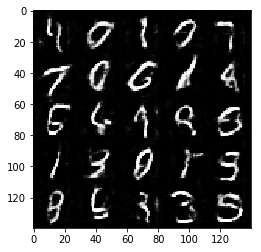

Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.2162
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.8596
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.0963
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.5888
Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 1.9957
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 1.9721
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 2.0072
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.2900
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 2.4594
Epoch 2/2... Discriminator Loss: 0.6729... Generator Loss: 2.1395


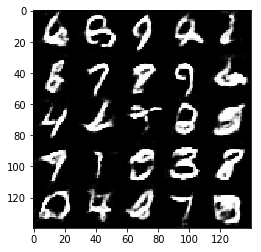

Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 0.9909
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.8002
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 1.5106
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.7214
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.6313


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.8417... Generator Loss: 0.1398
Epoch 1/1... Discriminator Loss: 1.9109... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 2.0474... Generator Loss: 0.3338
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 2.0304
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.9293
Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 2.2979
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 7.8313
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 3.8234
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 2.7952
Epoch 1/1... Discriminator Loss: 1.9700... Generator Loss: 6.4191


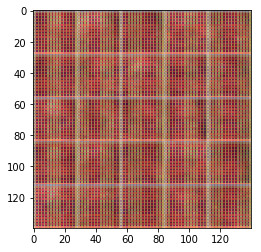

Epoch 1/1... Discriminator Loss: 5.2699... Generator Loss: 0.0252
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 3.6412
Epoch 1/1... Discriminator Loss: 3.4735... Generator Loss: 0.0802
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.2008
Epoch 1/1... Discriminator Loss: 1.8105... Generator Loss: 3.4512
Epoch 1/1... Discriminator Loss: 1.9893... Generator Loss: 0.2486
Epoch 1/1... Discriminator Loss: 1.8396... Generator Loss: 0.3884


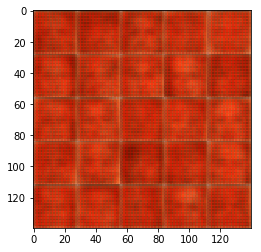

Epoch 1/1... Discriminator Loss: 1.7903... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.6246
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.9085


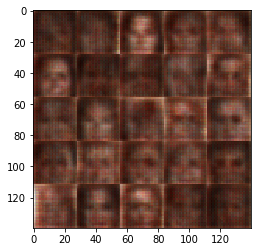

Epoch 1/1... Discriminator Loss: 1.9583... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 1.3414
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.6542
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.2950


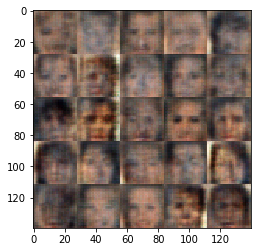

Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.8606


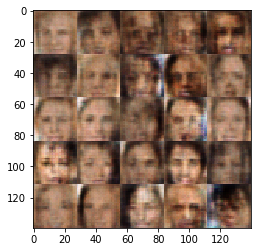

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.6702... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.8872


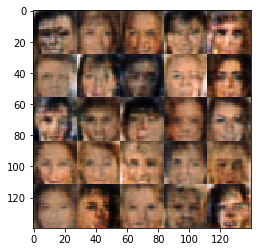

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.8983


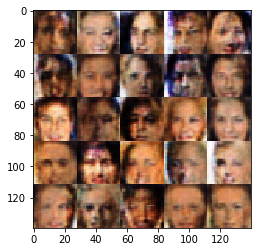

Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.4218


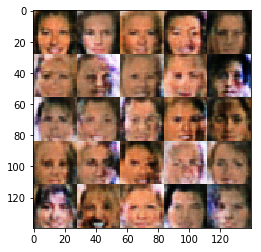

Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.1829
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6355


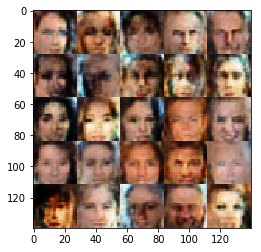

Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.8309


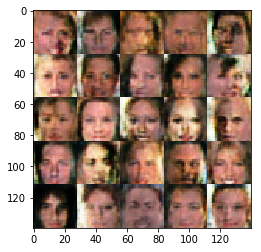

Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.7463
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.0677


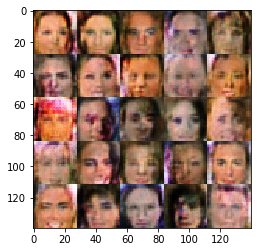

Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6248


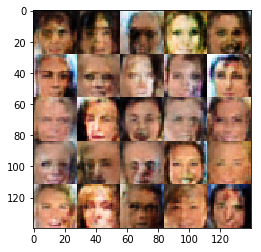

Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.6803


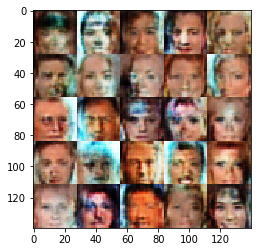

Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.4282


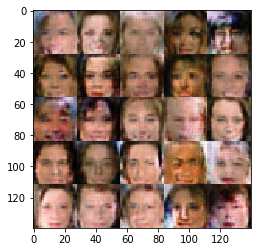

Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.9958


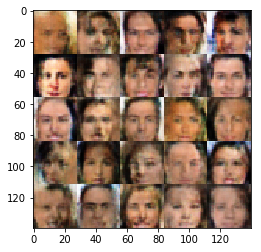

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.4794


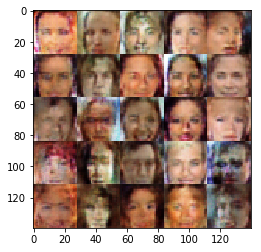

Epoch 1/1... Discriminator Loss: 1.8538... Generator Loss: 0.2993
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7643


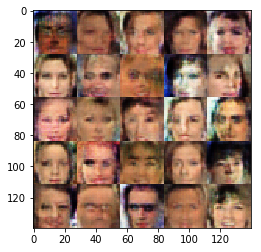

Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 1.5166
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.8351


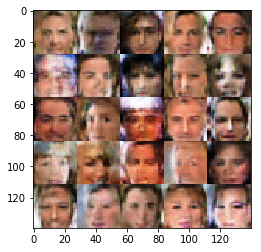

Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.9472


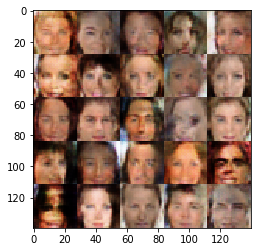

Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.9126... Generator Loss: 0.2783
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7982


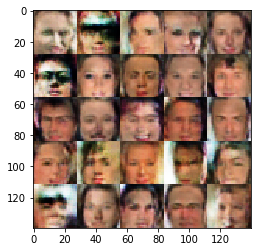

Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.9675


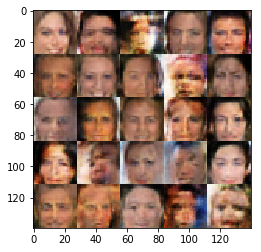

Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.6191... Generator Loss: 0.4860


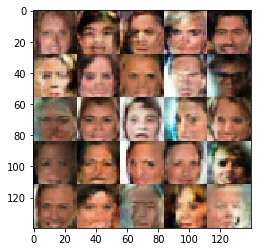

Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6760


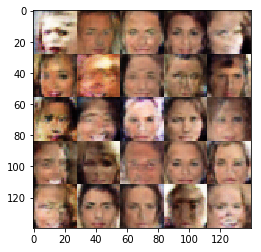

Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.6897


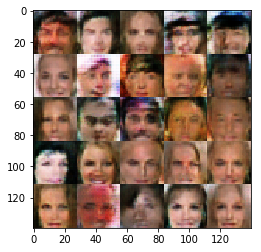

Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7877


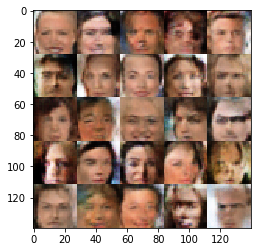

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.4191


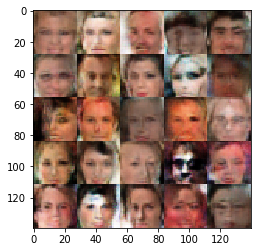

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.4448


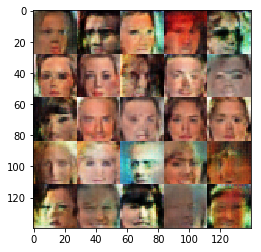

Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.6668... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7089


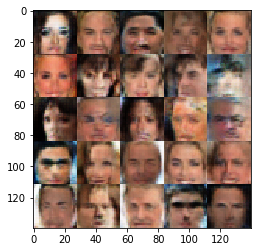

Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.0787


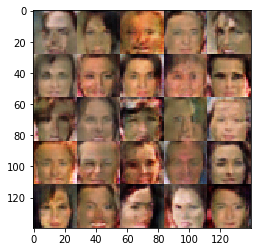

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.6701
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.9121


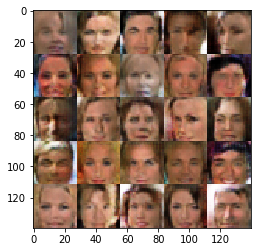

Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.9649


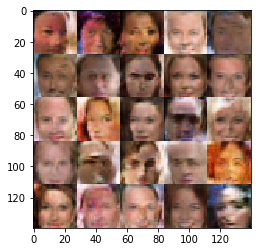

Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.4206


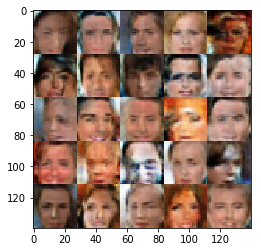

Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.7600


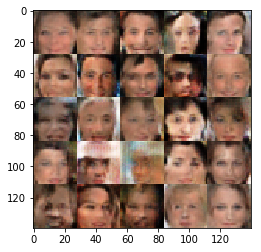

Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.8890


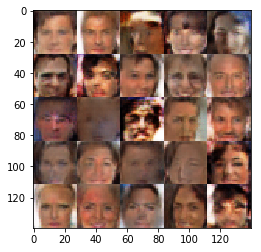

Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6143


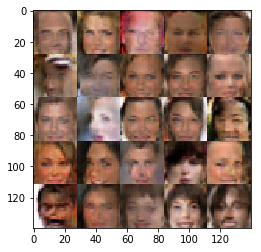

Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8546


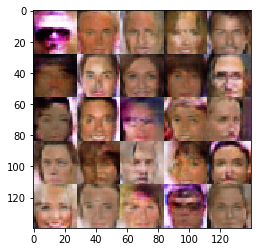

Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 1.0144


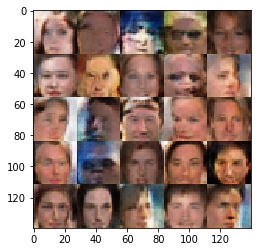

Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.0297


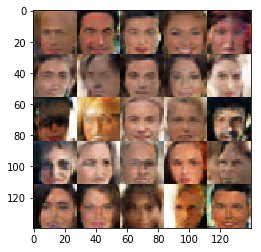

Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.7365
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.8751


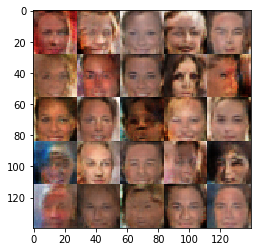

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.1747


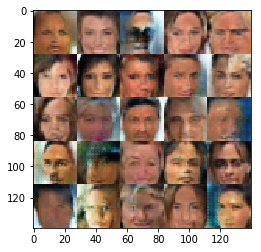

Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.5433


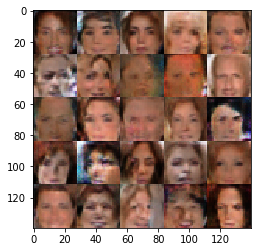

Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7551


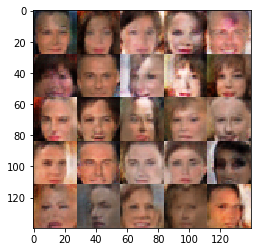

Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.4650


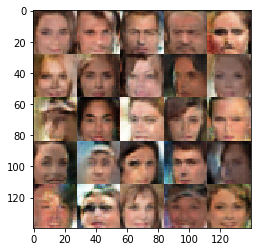

Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.9877... Generator Loss: 0.2570
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6478


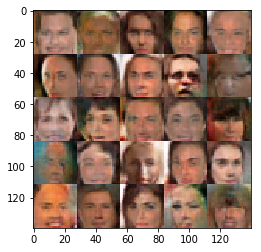

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.8811


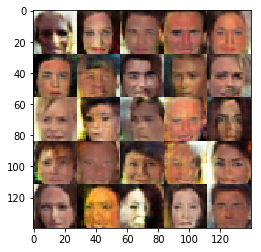

Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.1120


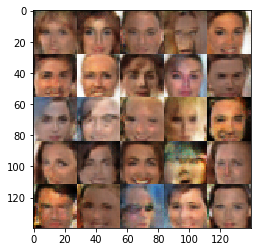

Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.4605


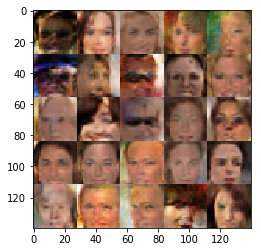

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.7717


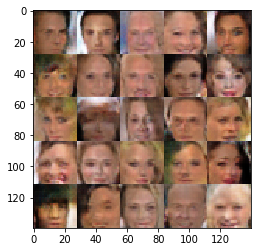

Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6671


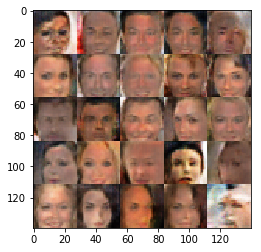

Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.9153


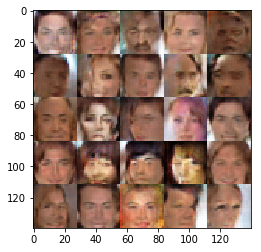

Epoch 1/1... Discriminator Loss: 1.7720... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7035


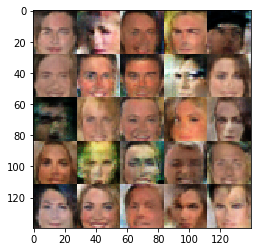

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7128


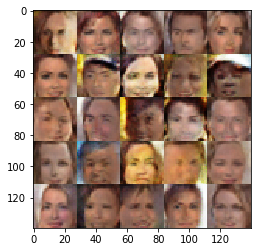

Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.8992


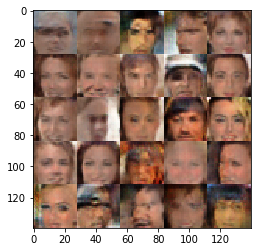

Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6402


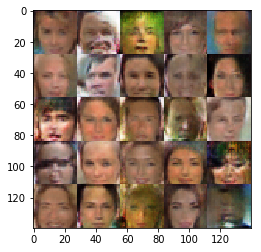

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.6943


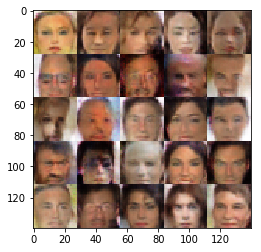

Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.6645... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.7332


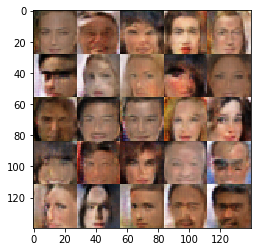

Epoch 1/1... Discriminator Loss: 1.8625... Generator Loss: 0.2999
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.6691


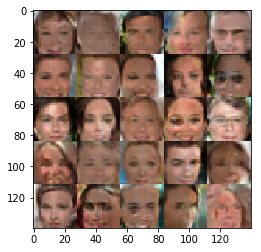

Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.3886


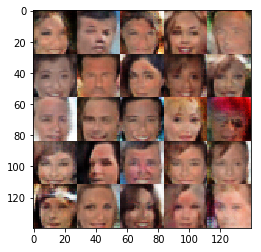

Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.8847


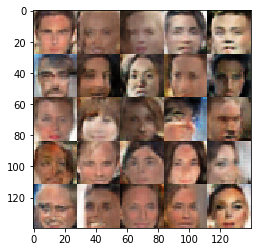

Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.3152
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.9589


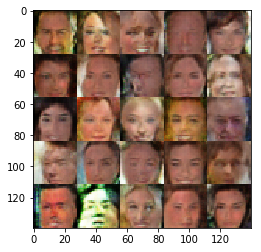

Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.4572


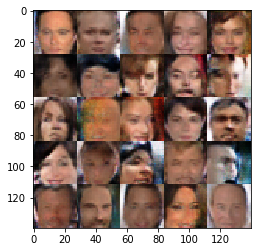

Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.4920


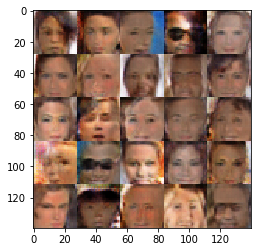

Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7190


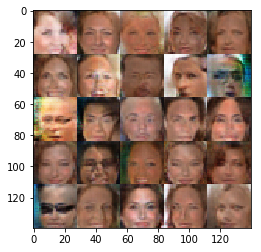

Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.8799


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.